# Seasonal Data Analysis & forecasting

- Dataset used: Employed Persons in Midwest Census Region ( 01/1976 to 02/2022)
- Goal        : Understanding Seasonal data, analysis and forecasting
- Developer: Yogesh Awdhut Gadade

<a id='index'></a>
# Content of the notebook:
1. <a href="#Section1"> Data loading, Preprocessing </a>
2. <a href="#Section2"> EDA </a>
3. <a href="#Section3"> Stationarity check</a>
    - Seasonality, trend, Decomposition, ADF test
    - ACF, PACF 
4. <a href="#SectionMakeStationary">Making Employed Person data stationary</a>
5. <a href="#Section4"> Time Series Forecasting analysis with ARIMA - Fitting, Validating </a>
6. <a href="#Section5"> Facebook Prophet</a>
7. <a href="#Section6"> Comparision of results</a>

In [1]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8  # defining all figure size in this notebook
import matplotlib.pyplot as plt
import pandas as pd

<a id='Section1'></a>
# Data Preprocessing

- This step includes-studying data, removin not required columns, check missing values, aggregate sales by date and so on.

In [2]:
! pip install xlrd 

Traceback (most recent call last):
  File "c:\users\yoges\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\yoges\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\yoges\anaconda3\Scripts\pip.exe\__main__.py", line 4, in <module>
ModuleNotFoundError: No module named 'pip'


In [3]:
pdInput=pd.read_excel("Jan1976-Feb2022.xls",  skiprows=10, index_col=None)
pdInput.head(5)

,observation_date,LAURD920000000000005
0,1976-01-01,23497992
1,1976-02-01,23587085
2,1976-03-01,23817394
3,1976-04-01,24129936
4,1976-05-01,24410151


In [4]:
# Renaming the column names
pdInput=pdInput.rename(columns={'observation_date': "Monthly", "LAURD920000000000005": "Values"})
pdInput.head(5)

,Monthly,Values
0,1976-01-01,23497992
1,1976-02-01,23587085
2,1976-03-01,23817394
3,1976-04-01,24129936
4,1976-05-01,24410151


In [5]:
#check missing values
pdInput.isnull().sum() # we have 0 null / missing values. Hence no need to impute the values

Monthly    0
Values     0
dtype: int64

In [6]:
len(pdInput) # we have total 554 Datapoints 

554

In [7]:
(2022-1976) * 12 + 2 # ( Jan and Feb of 2022) Shows we do not have any missing value for any month

554

In [8]:
pdInput.dtypes # we have one date time column and one interger value column hence already present in desired dtypes. 

Monthly    datetime64[ns]
Values              int64
dtype: object

<a id='Section2'></a>
# 2. EDA

In [9]:
print("""Data is from {} to {} \nEmployed Persons Values are in the range of ({}, {})"""\
      .format(pdInput.Monthly.min(), pdInput.Monthly.max(), pdInput.Values.min(), pdInput.Values.max()) )

# our time series is:
y = pdInput.set_index("Monthly")
y.head()

Data is from 1976-01-01 00:00:00 to 2022-02-01 00:00:00 
Employed Persons Values are in the range of (23497992, 34346625)


,Values
Monthly,
1976-01-01,23497992
1976-02-01,23587085
1976-03-01,23817394
1976-04-01,24129936
1976-05-01,24410151


Mid West Region Employed Persons count distribution


[]

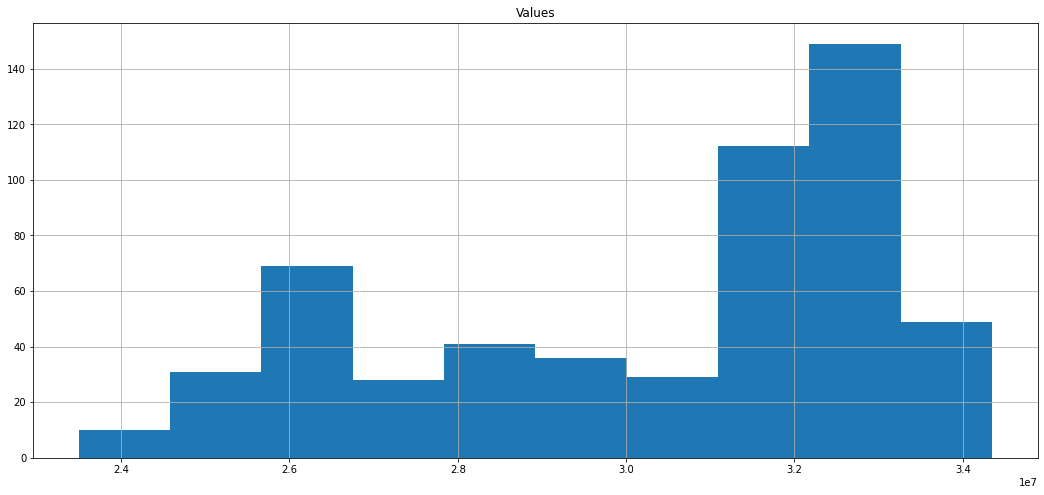

In [10]:
print("Mid West Region Employed Persons count distribution")
y.hist() 
plt.plot() 

In [11]:
# Observation: distribution of values its not as normal bell shape its having tail towards left hence skewed towards left

In [12]:
y.describe().apply(lambda x: round(x, 2))

,Values
count,554.00
mean,30279643.10
std,2843592.61
min,23497992.00
25%,27886241.00
50%,31496412.50
75%,32569397.75
max,34346625.00


In [13]:
# Observation: values range from (23497992, 34346625) with mean as 30279643.10, std as 2843592.61 in 554 values 

<a id='Section3'></a>

# 3. Stationarity Check

- Stationarity is a key part of time series analysis. Simply put, stationarity means that the manner in which time series data changes is constant. 
- A stationary time series will not have any trends or seasonal patterns. 
- You should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. 
- Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

source: https://builtin.com/data-science/time-series-python

### Non-Stationary Time Series
- Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.
- Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.
- Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

### Stationary Time Series
- The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. When a time series is stationary, it can be easier to model. 
- Statistical modeling methods assume or require the time series to be stationary to be effective.


### Should you make your time series stationary?
- Generally, yes.
- If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.
- If we fit a stationary model to data, we assume our data are a realization of a stationary process. So our first step in an analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them.

#### Checks for Stationarity
There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.
1. Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
2. Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
3. Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.
    - For example We can use the Dickey Fuller test to check for stationarity in our data. This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity. These values allow us to test the degree to which present values change with past values. If there is no stationarity in the data set, a change in present values will not cause a significant change in past values.

### Method 1: Visualization - plot of time series data


#### Seasonality Check
- **Seasonality** in a time series is a regular pattern of changes that repeats over S time periods, where S defines the number of time periods until the pattern repeats again.

- For example, there is seasonality in monthly data for which high values tend always to occur in some particular months and low values tend always to occur in other particular months. 
- In this case, S = 12 (months per year) is the span of the periodic seasonal behavior. For quarterly data, S = 4 time periods per year.

[]

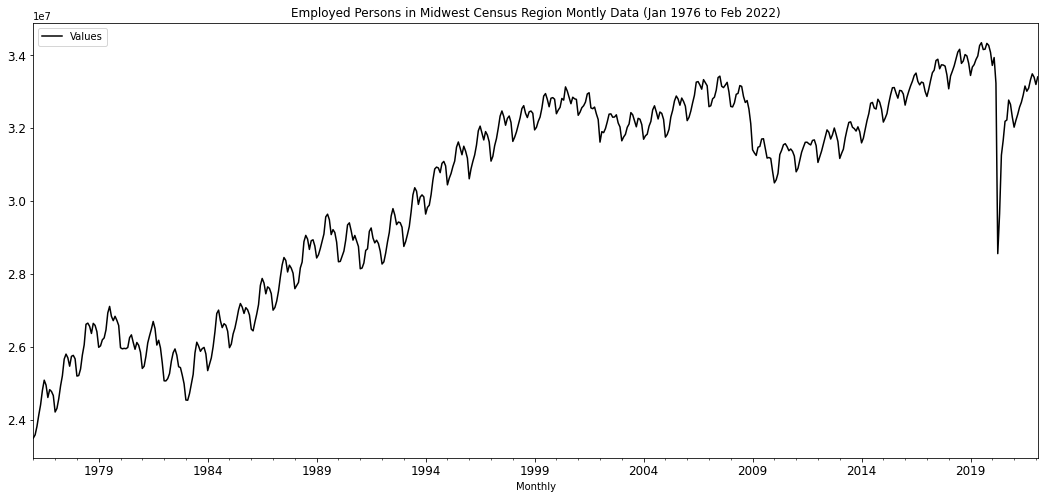

In [14]:
y.plot(title="Employed Persons in Midwest Census Region Montly Data (Jan 1976 to Feb 2022)", \
       color = ['k'], fontsize = '12', rot ='0' ) 
plt.plot()

In [15]:
# Observation: # It shows there is seasonality in the data

#### Observation: As it can be seen there is sesonal patter in the graph but at one point it breaks after 2019 ( due to Covid situation )

<AxesSubplot:title={'center':"'1979':'1980' plot observe rise in every July and Oct"}, xlabel='Monthly'>

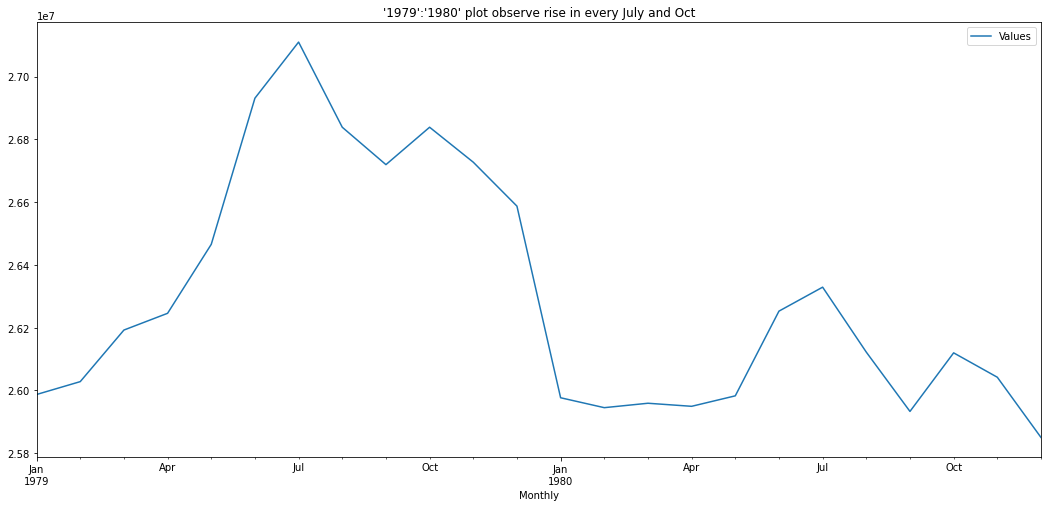

In [16]:
# Magnifying the graphs to see the seasonal patter in the graphs
y['1979':'1980'].plot(title="""'1979':'1980' plot observe rise in every July and Oct""") # there is rise in every July and Oct 

<AxesSubplot:title={'center':"'1981':'1982' plot observe rise in every July and Oct"}, xlabel='Monthly'>

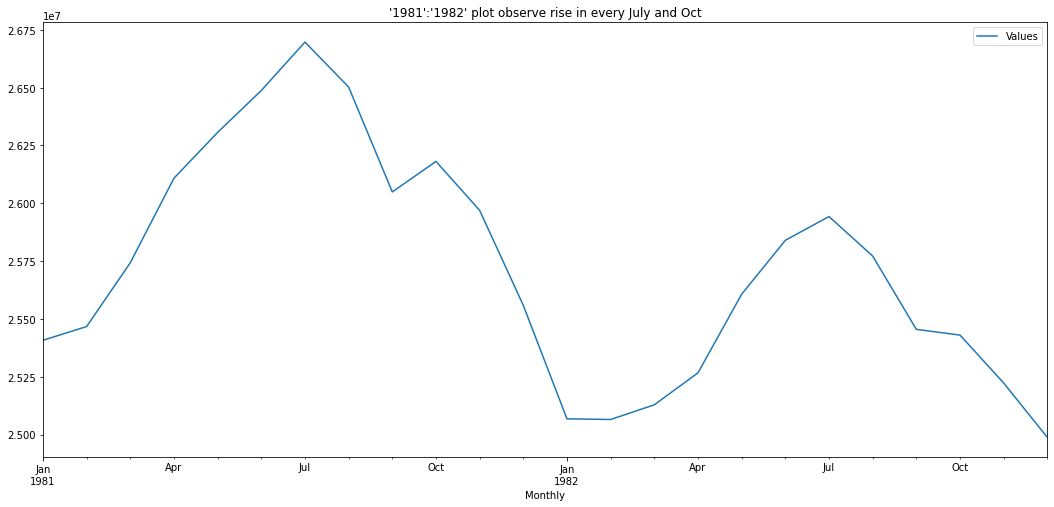

In [17]:
y['1981':'1982'].plot(title="""'1981':'1982' plot observe rise in every July and Oct""")  # there is rise in every July and Oct 

<AxesSubplot:title={'center':"'1983':'1984' plot observe rise in every July and Oct"}, xlabel='Monthly'>

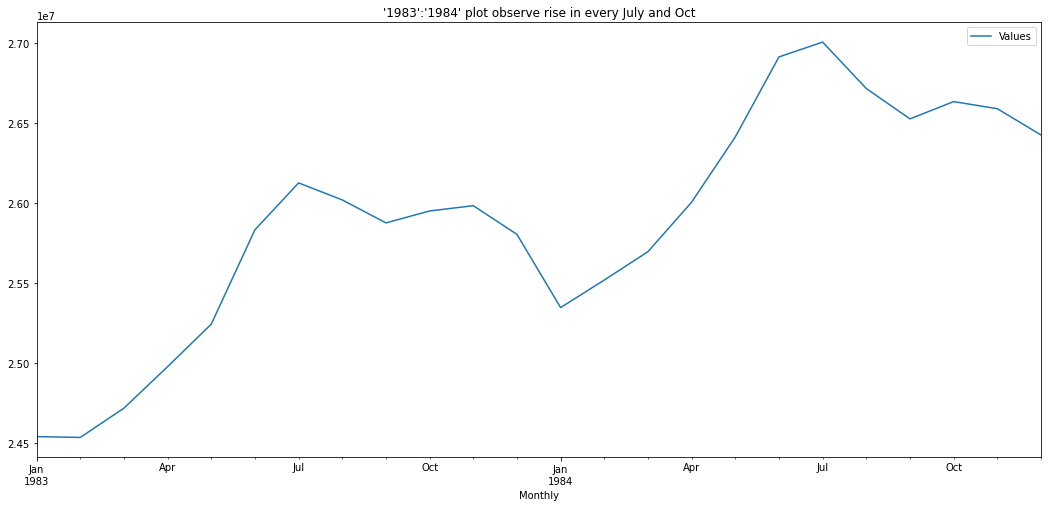

In [18]:
y['1983':'1984'].plot(title="""'1983':'1984' plot observe rise in every July and Oct""")  # there is rise in every July and Oct 

<AxesSubplot:xlabel='Monthly'>

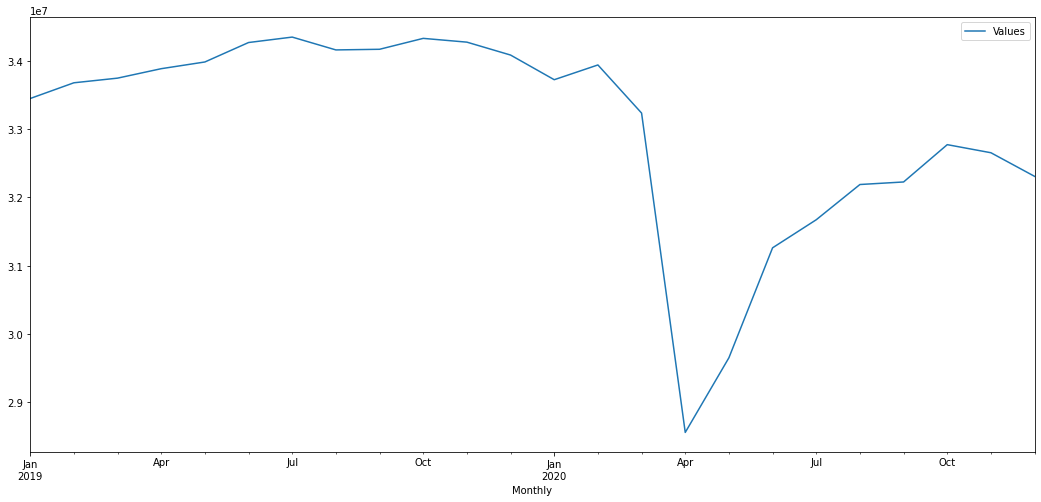

In [19]:
# Noticed significant drop at one point of time
y['2019':'2020'].plot()# In July and Oct it can be seen that employment is rised, deep dive at April

### Method 2: Visualization  - Rolling mean and std

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

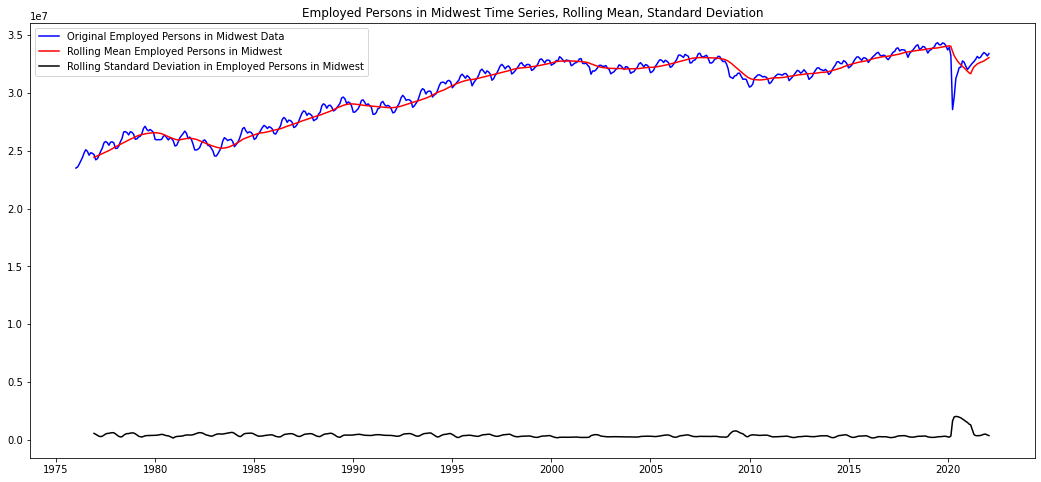

In [20]:
#Let’s test for stationarity in our data. To start, let’s calculate a 12-month rolling mean:
rolling_mean = y.rolling(12).mean()
rolling_std  = y.rolling(12).std()

#let’s overlay our time series with the seven-month rolling mean and seven-month rolling standard deviation. 
# First, let’s make a Matplotlib plot of our time series:
plt.plot(y, color="blue",label="Original Employed Persons in Midwest Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Employed Persons in Midwest")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Employed Persons in Midwest")
plt.title("Employed Persons in Midwest Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

# Observation: 12 month rolling mean shows there is trend and std graph is mostly not significantly
# fluctuaating except at 2020

### Method 3: Visualization - Decomposition to check trend Vs seasonality

In [21]:
!pip install statsmodels

Traceback (most recent call last):
  File "c:\users\yoges\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\yoges\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\yoges\anaconda3\Scripts\pip.exe\__main__.py", line 4, in <module>
ModuleNotFoundError: No module named 'pip'


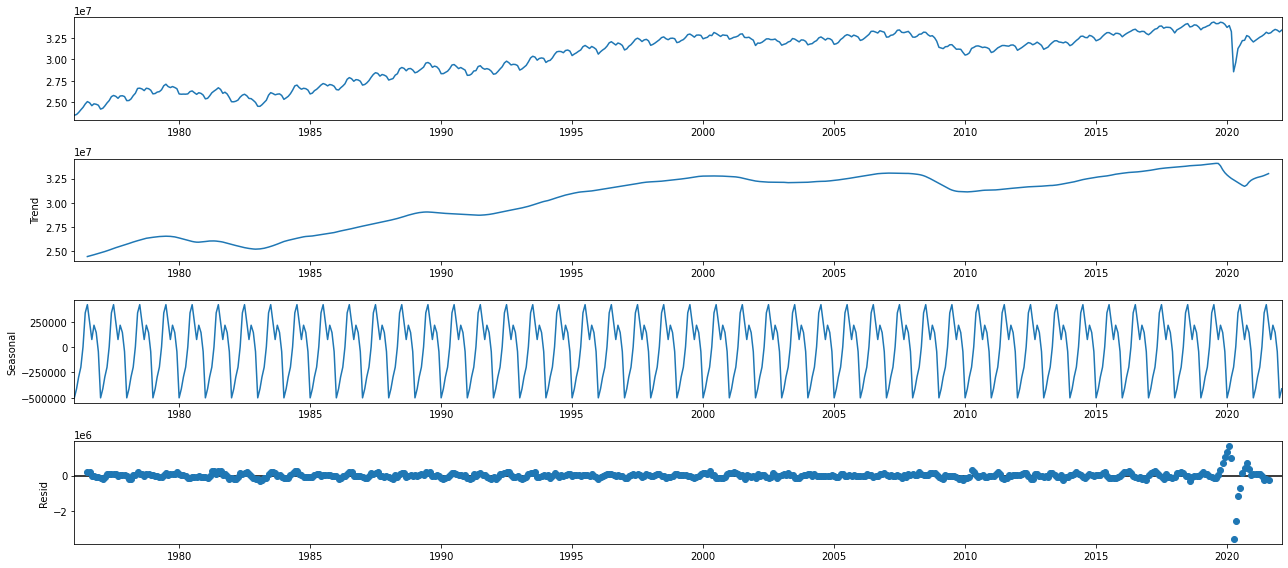

In [22]:
#Trend vs. Seasonality
#The next piece is actually running the seasonal decomposition. The dataframe is passed in as an argument 
#as well as period=12 to represent our monthly data and find year-over-year seasonality.
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=12)
fig = decomposition.plot()
plt.show()

In [23]:
### Observations: Overall above decomposition shows:
#1. There is rising trend in the employment
#2. There is seasonality
#3. Residual are close to central lines except in 2022

### Method 4: Looking at Mean and Variance
Because we are looking at the mean and variance, we are assuming that the data conforms to a Gaussian (also called the bell curve or normal) distribution. 
- We can also quickly check this by eyeballing a histogram of our observations.
- Running the example plots a histogram of values from the time series. We clearly see the bell curve-like shape of the Gaussian distribution, perhaps with a longer right tail.
- Next, we can split the time series into two contiguous sequences. We can then calculate the mean and variance of each group of numbers and compare the values.

In [24]:
# Checking the stationarity 
# Cutting straight to the chase, we can split our dataset and calculate the mean and variance for each group.

split = round(len(y) / 2)
y1, y2 = y[0:split], y[split:]
mean1, mean2 = y1.mean(), y2.mean()
var1, var2 = y1.var(), y2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=28053306.462094, mean2=32505979.747292
variance1=5523821623899.299805, variance2=728446520107.175049


In [25]:
# Observation: Running the example, we can see the mean and variance look very different. 
# We have a non-stationary time series.

[]

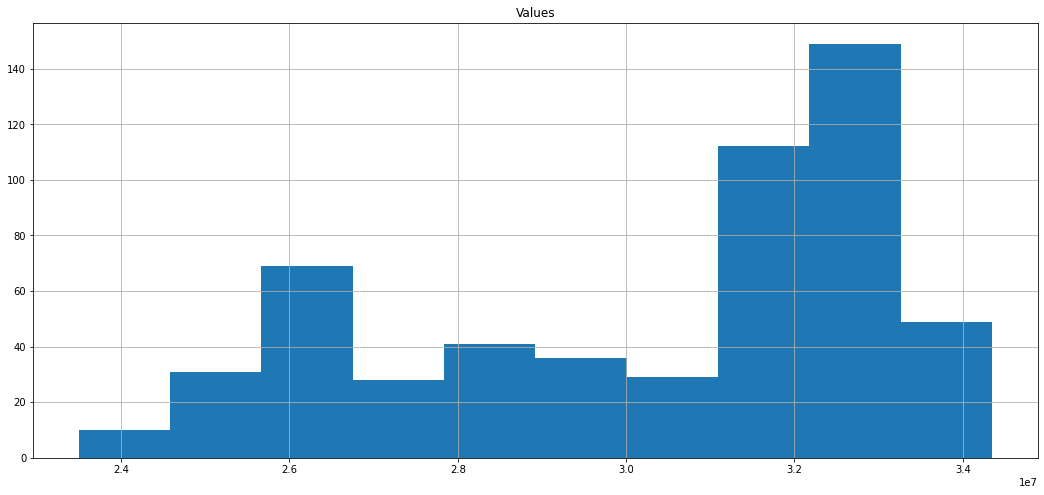

In [26]:
# Now let's check the histogram
y.hist()
plt.plot()

In [27]:
## Observation: 
# 1. Running the example shows that indeed the distribution of values does not look like a Gaussian, 
# therefore the mean and variance values are less meaningful.
# 2. This squashed distribution of the observations may be another indicator of a non-stationary time series.

### Method 5: Augmented Dickey-Fuller test
- Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.
- Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [28]:
from statsmodels.tsa.stattools import adfuller
#adfuller gives 5 values ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
#most imp is p-value this is almost similar to Hypothesis testing, whereas Null hypo which says Data is not Stationery
#whereas Alternate hypo says data is stationery
###if Pvalue<0.05 ,we reject Null hypo i.e. alternate hypo is true,i.e. data is stationary
#zip basically combines result,labels

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(y)


ADF Test Statistic : -1.5281879368261195
p-value : 0.5195239602523655
#Lags Used : 16
Number of Observations Used : 537
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [29]:
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.528188
p-value: 0.519524
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [30]:
# source: https://www.kaggle.com/code/avi111297/predicting-sales-using-arima-sarimax-tsf-model

### Observation:
- ADF statistic value of -1.5
    - The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).
- p value is 0.52 > 0.5 
    - hence accepting null hypothesis. Indicating data is not stationary.
- As part of the output, we get a look-up table to help determine the ADF statistic. 
    - We can see that our statistic value of -1.5 is more than the value of -3.443 at 1%. This suggests that fail to reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
- Accepting the null hypothesis means that the data has a unit root and is non-stationary and does have time-dependent structure.

Source: https://machinelearningmastery.com/time-series-data-stationary-python/

Note: In case the test statistic is positive, meaning we are much less likely to reject the null hypothesis.

Go back to <a href="#index">Content of the notebook index</a>

### Method 6: Ljung-Box test (optional - not able to comprehend completely)

The Ljung-Box test is a statistical test that checks if autocorrelation exists in a time series.

It uses the following hypotheses:

H0: The residuals are independently distributed.

HA: The residuals are not independently distributed; they exhibit serial correlation.

Ideally, we would like to fail to reject the null hypothesis. That is, we would like to see the p-value of the test be greater than 0.05 because this means the residuals for our time series model are independent, which is often an assumption we make when creating a model.

In [31]:
#fit ARMA model to dataset
res = sm.tsa.ARMA(y, (1,1)).fit(disp=-1)
#perform Ljung-Box test on residuals with lag=1 to 40
sm.stats.acorr_ljungbox(res.resid, lags=None, return_df=True)
#This function returns a test statistic and a corresponding p-value. 
# If the p-value is less than some threshold (e.g. α = .05), you can reject the null hypothesis and 
# conclude that the residuals are not independently distributed.

C:\Users\yoges\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\yoges\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS wi

,lb_stat,lb_pvalue
1,0.183282,6.685677e-01
2,3.204933,2.013992e-01
3,5.592822,1.331910e-01
4,5.625990,2.288749e-01
5,8.638964,1.243605e-01
6,16.713773,1.039478e-02
7,17.808292,1.286555e-02
8,21.212126,6.604780e-03
9,24.315278,3.829730e-03
10,24.396333,6.615105e-03


In [32]:
### Observation: 
#1. from lag=8 Ib_pvalue drops to less than 0.05 => Rejecting null hypothesis concluding the residuals 
# are not independently distributed

### Method 7: Checking ACF and PACF
##### Correlation and Autocorrelation

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

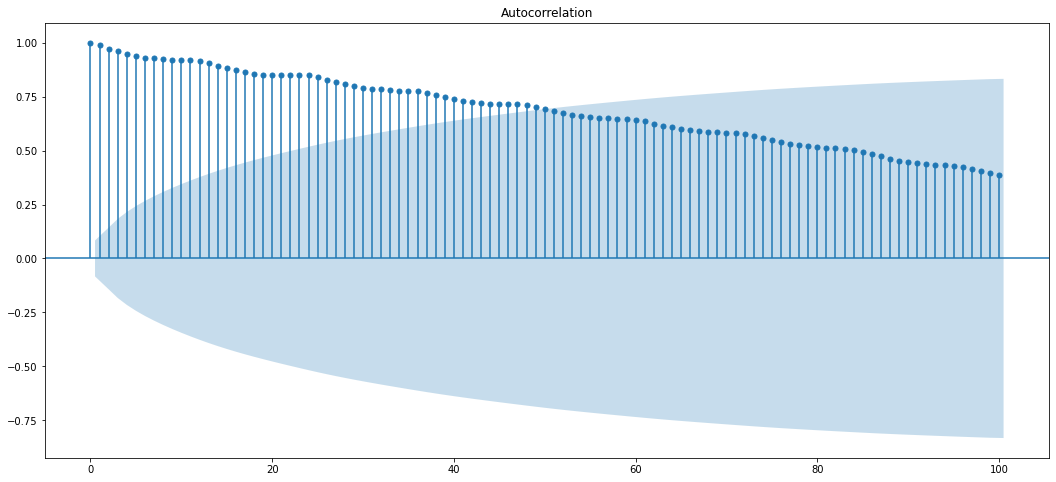

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#creates a 2D plot showing the lag value along the x-axis and the correlation on the y-axis between -1 and 1.
plot_acf(y, lags=100)
plt.show()
#Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting
#that correlation values outside of this code are very likely a correlation and not a statistical fluke.

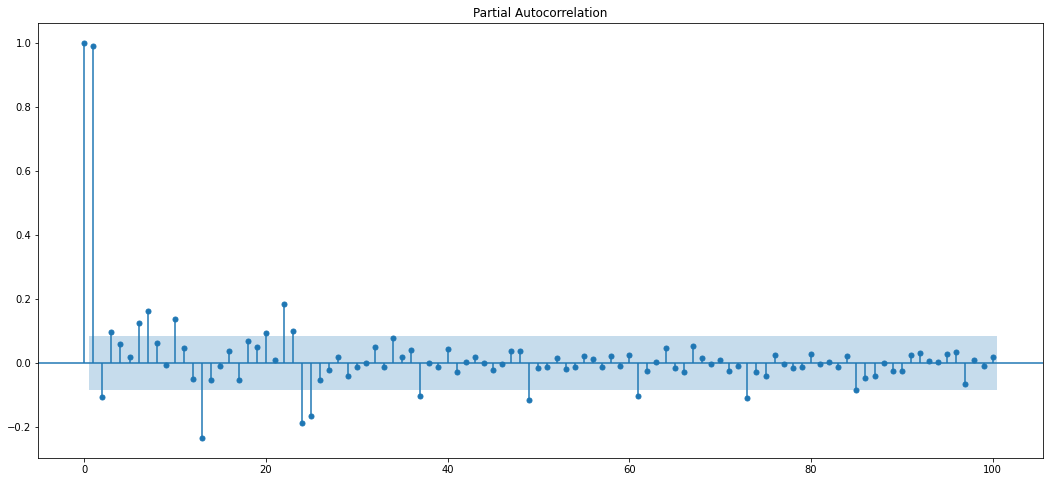

In [34]:
plot_pacf(y, lags=100)
plt.show()

In [35]:
# Observation - hard to see any seasonal pattern or repeatations.
#There is slight wave like repeatation though after every 6/7 spikes changes in case of ACF

#### Conclusion of Stationarity Checks:
- From methods: plot of time series data, the seasonal decomposition plot, Looking at Mean and Variance it's clear that we have non stationary time series data which is having seasonality and trend in it. 
- We will need to make it stationary before finding the parameters 

<a id='SectionMakeStationary'></a>
# 4. Making Employed Person data stationary

#### Non-Stationary Time Series
1. Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.
2. Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.
3. Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing stationary effects.

#### Why to make data stationary?
1. The observations in a stationary time series are not dependent on time.
2. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
3. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.


### Method 1: Differencing to make data stationary

#### Difference Transform
- Differencing is a method of transforming a time series dataset.
- It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality.
    - "Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality." — Page 215, Forecasting: principles and practice.

- Differencing is performed by subtracting the previous observation from the current observation.
    - difference(t) = observation(t) - observation(t-1)
- Inverting the process is required when a prediction must be converted back into the original scale.
- This process can be reversed by adding the observation at the prior time step to the difference value.
    - inverted(t) = differenced(t) + observation(t-1)
- In this way, a series of differences and inverted differences can be calculated.

Source: https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/

<AxesSubplot:xlabel='Monthly'>

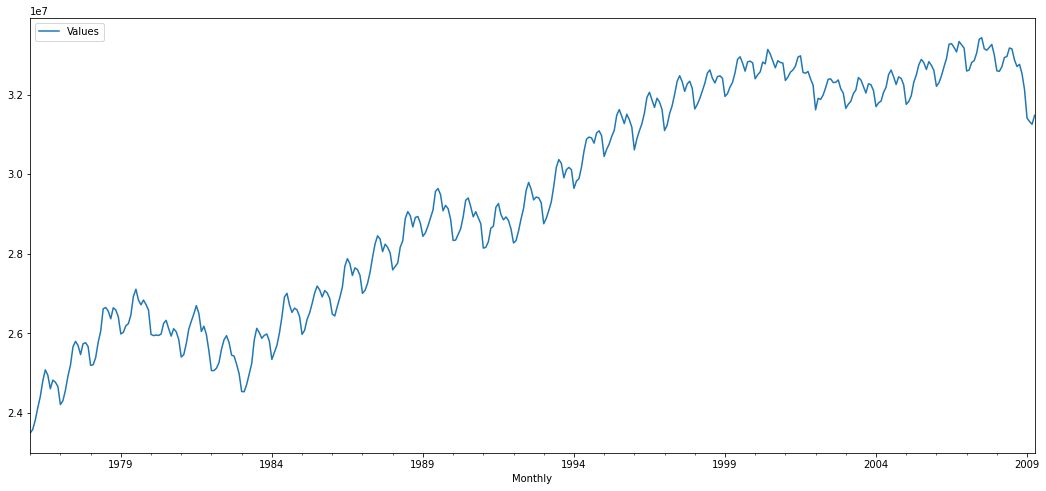

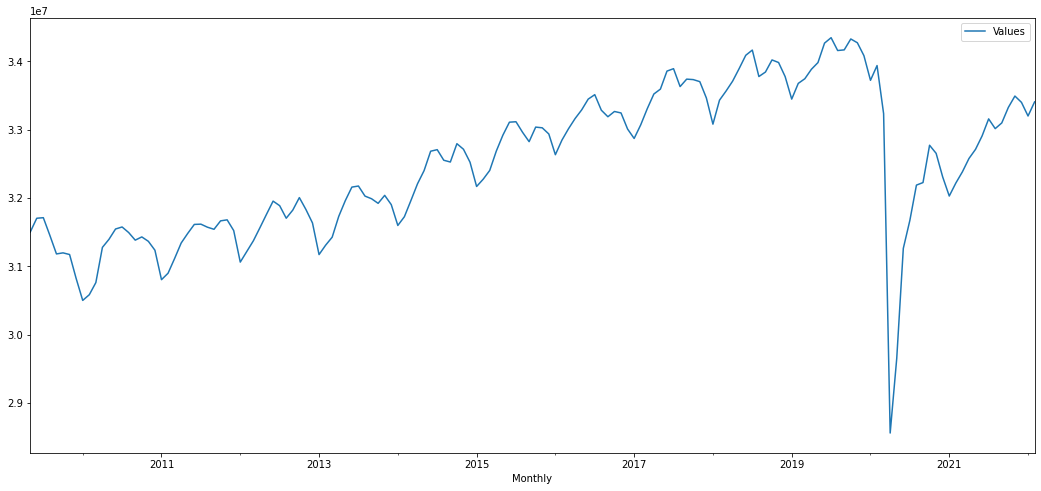

In [36]:
# Spliting data into training and testing sets 
from pmdarima import model_selection
train, test = model_selection.train_test_split(y, train_size=400)

train.plot()
test.plot()

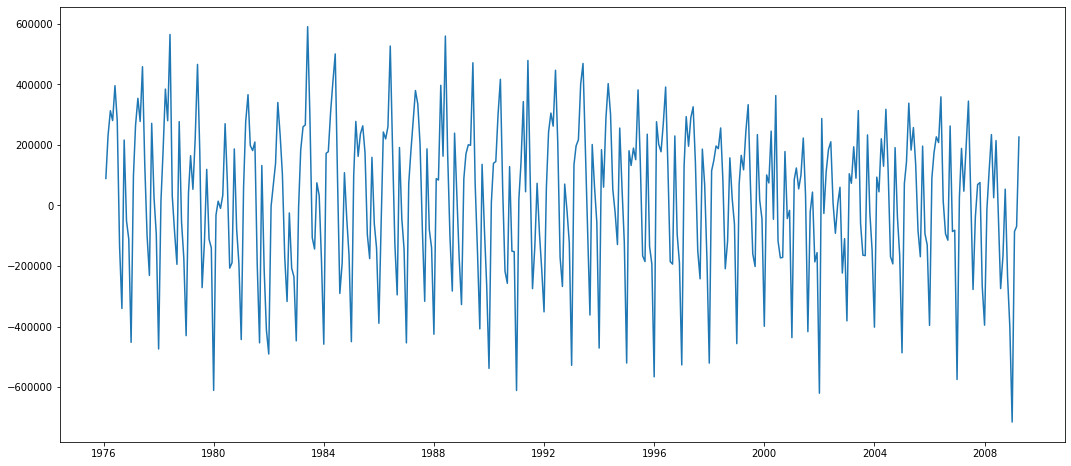

In [37]:
plt.plot(train.diff(periods=1)) #built-in Pandas implementation of the difference transform. 
#it takes an argument to specify the interval or lag, in this case called the periods.

In [38]:
#source: https://machinelearningmastery.com/difference-time-series-dataset-python/

[]

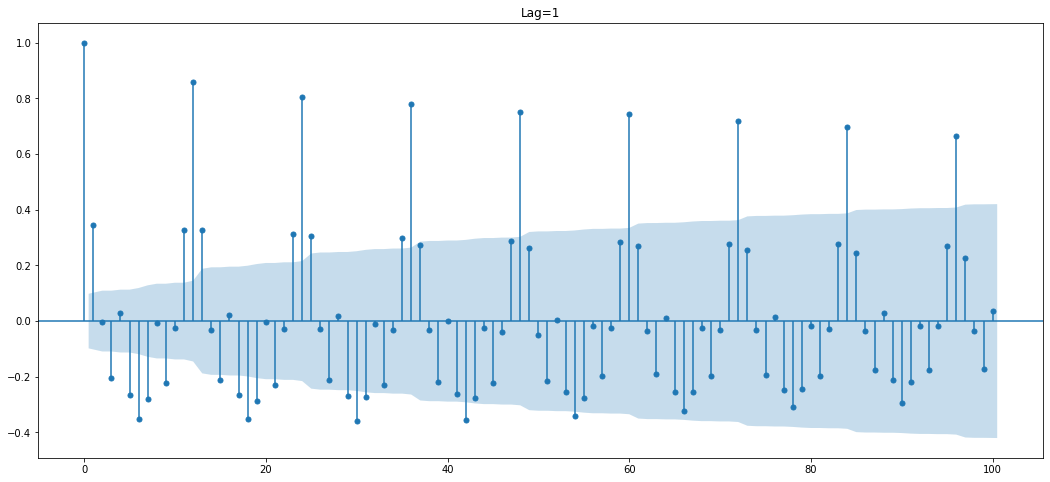

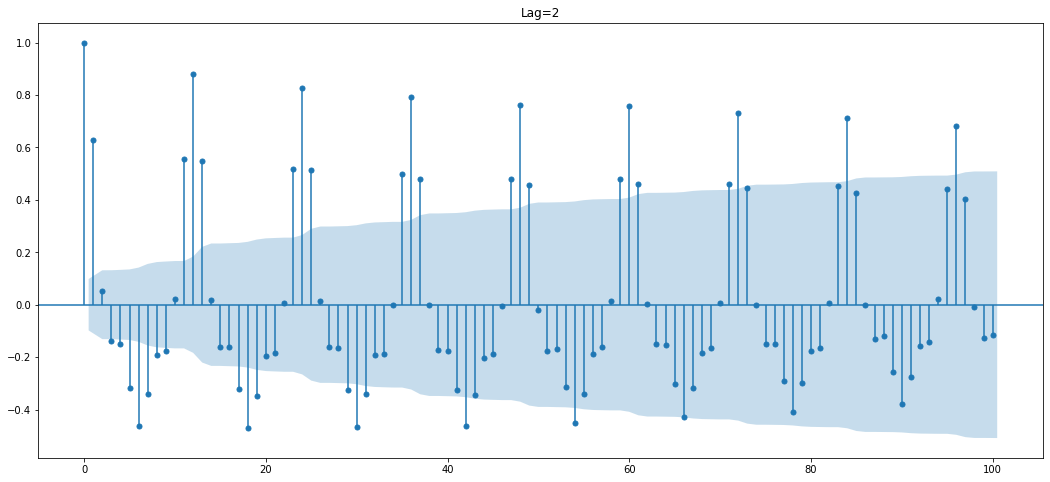

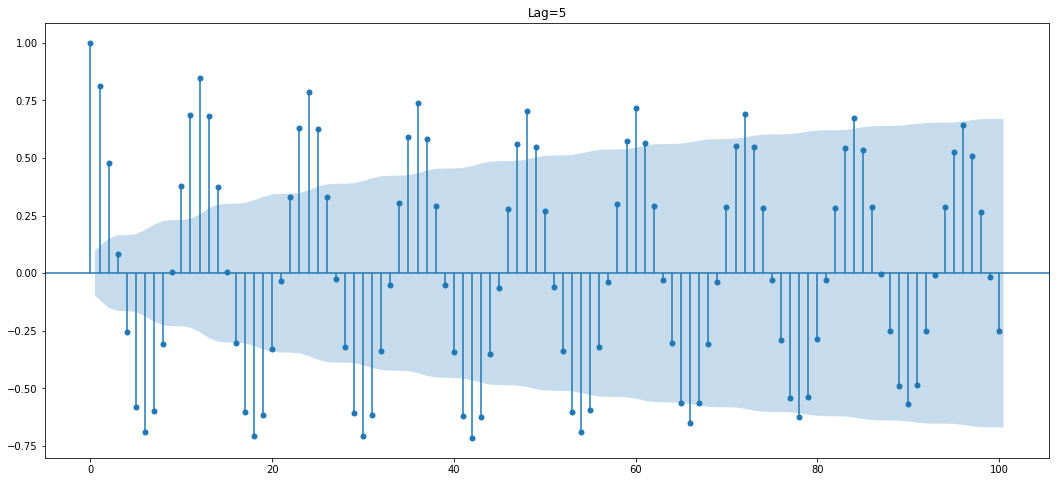

In [39]:
plot_acf(train.diff(periods=1).dropna(), lags=100, title="Lag=1") # Observation: Remove nan else acf will not plot anything
plot_acf(train.diff(periods=2).dropna(), lags=100, title="Lag=2") # Observation: Remove nan else acf will not plot anything
plot_acf(train.diff(periods=5).dropna(), lags=100, title="Lag=5") # Observation: Remove nan else acf will not plot anything
plt.plot()

In [40]:
# Observations:
# For the difference with lag/periods as 1 and 2 having lots of spikes outside the confidance interval ( continue till 10)
# For the difference with lag/periods as 11 we can see after lag=9 in ACF all the spikes lying inside the interval
# But not sure hence let's perform ADF test again

In [41]:
adfuller_test(train)

ADF Test Statistic : -1.495879471019243
p-value : 0.535548711951088
#Lags Used : 15
Number of Observations Used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [42]:
print("\nOriginal")
adfuller_test(train)
print("\nTaken difference with periods=1")
adfuller_test(train.diff(periods=1).dropna())
print("\nTaken difference with periods=2")
adfuller_test(train.diff(periods=2).dropna())
print("\nTaken difference with periods=3")
adfuller_test(train.diff(periods=3).dropna())
print("\nTaken difference with periods=4")
adfuller_test(train.diff(periods=4).dropna())
print("\nTaken difference with periods=5")
adfuller_test(train.diff(periods=5).dropna())


Original
ADF Test Statistic : -1.495879471019243
p-value : 0.535548711951088
#Lags Used : 15
Number of Observations Used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

Taken difference with periods=1
ADF Test Statistic : -2.6247162356581226
p-value : 0.08799575776313118
#Lags Used : 14
Number of Observations Used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

Taken difference with periods=2
ADF Test Statistic : -2.6307815441580176
p-value : 0.0868007526837587
#Lags Used : 13
Number of Observations Used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

Taken difference with periods=3
ADF Test Statistic : -2.69709450270456
p-value : 0.07454239787649622
#Lags Used : 17
Number of Observations Used : 379
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

Taken di

### Observations: For difference periods=4 and 5
- ADF statistic value of ~ -5. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).
- p value is 0.000056 < 0.5 hence rejecting null hypothesis. Indicating data is stationary.
- As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -5 is less than the value of -3.443 at 1%. This suggests that rejects the null hypothesis with a significance level of less than 1%. Hence rejecting null hypothesis.
- Rejecting the null hypothesis means the data does not have a unit root and is stationary and does not have time-dependent structure.

### Another way of calculation
result = adfuller(y.diff(periods=1).dropna())
print('\nLag 1: ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
result = adfuller(y.diff(periods=2).dropna())
print('\nLag 2: ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
result = adfuller(y.diff(periods=5).dropna())
print('\nLag 5: ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Method 2: Taking log to make data stationary

In [43]:
from numpy import log, log2, log10
print("\nTaken natural logarithm")
adfuller_test(log(train))# Calculate natural logarithm
print("\nTaken logarithm base 2")
adfuller_test(log2(train))# Calculate logarithm to base 2
print("\nTaken logarithm base 10")
adfuller_test(log10(train))# Calculate logarithm to base 10


Taken natural logarithm
ADF Test Statistic : -1.5151701231577939
p-value : 0.5259939944490863
#Lags Used : 15
Number of Observations Used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

Taken logarithm base 2
ADF Test Statistic : -1.515170123157805
p-value : 0.5259939944490807
#Lags Used : 15
Number of Observations Used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

Taken logarithm base 10
ADF Test Statistic : -1.5151701231578576
p-value : 0.5259939944490547
#Lags Used : 15
Number of Observations Used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Conclusion:
- From difference and log transformation we can conclude that difference is working
- Therefore I am going to take lag/periods=5

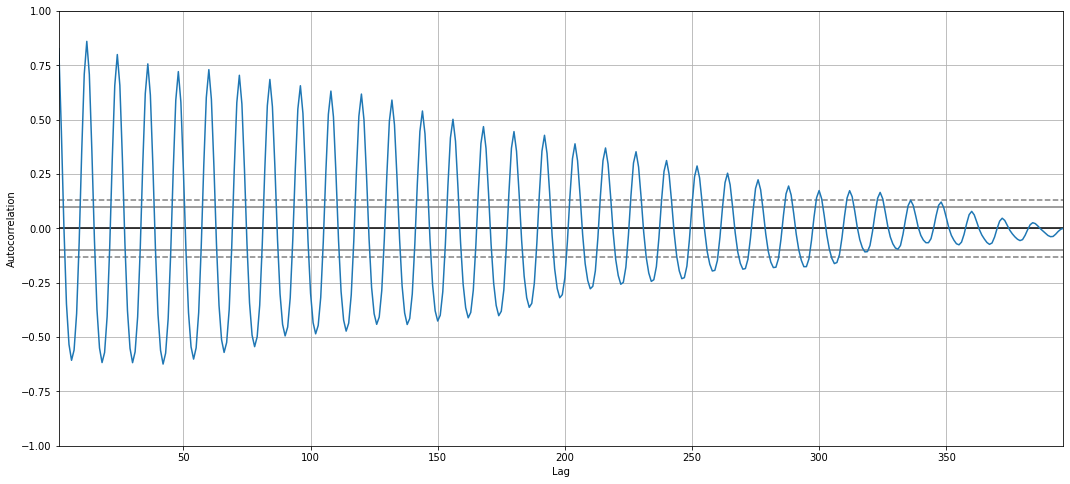

In [44]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train.diff(periods=4).dropna())
plt.show()

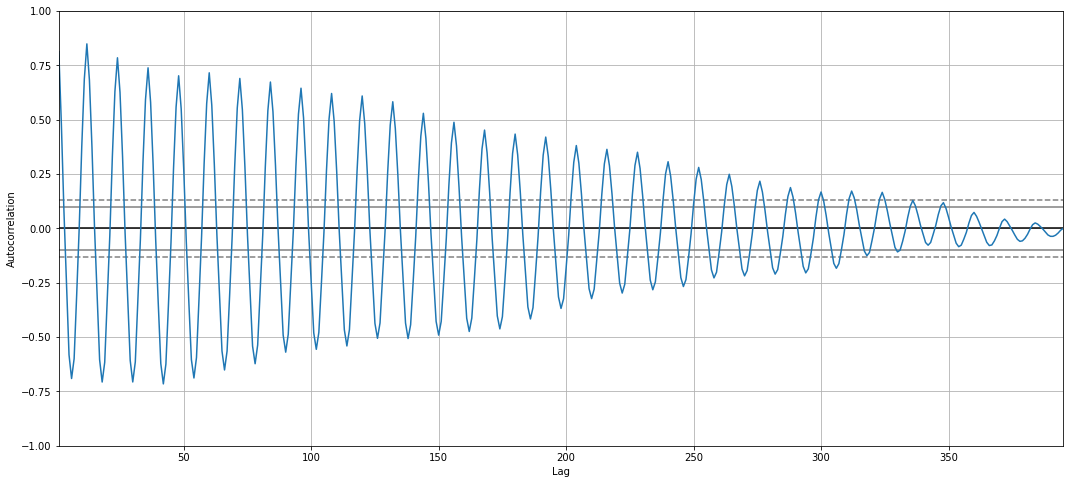

In [45]:
autocorrelation_plot(train.diff(periods=5).dropna())
plt.show()

### Observations: 
- The correlogram does not show any obvious autocorrelation pattern.
- There are some spikes above the 95% and 99% confidence level, but these are a statistical fluke

Source: https://machinelearningmastery.com/white-noise-time-series-python/

Autocorrelation and Partial Autocoorelation
- Identification of an AR model is often best done with the PACF.
- For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor. 
- Identification of an MA model is often best done with the ACF rather than the PACF. For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model. 

p,d,q p AR model lags d differencing q MA lags

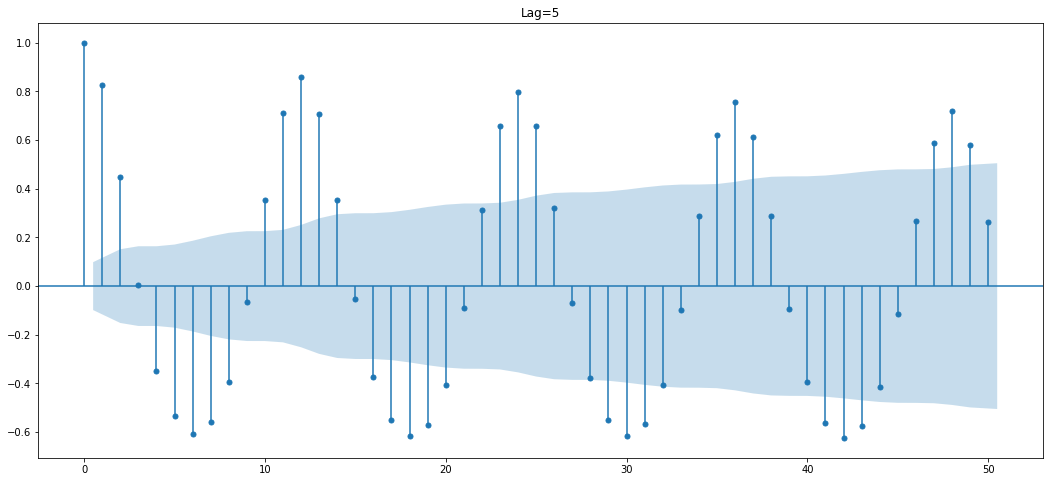

In [46]:
plot_acf(train.diff(periods=4).dropna(), lags=50, title="Lag=5") 
plt.show()

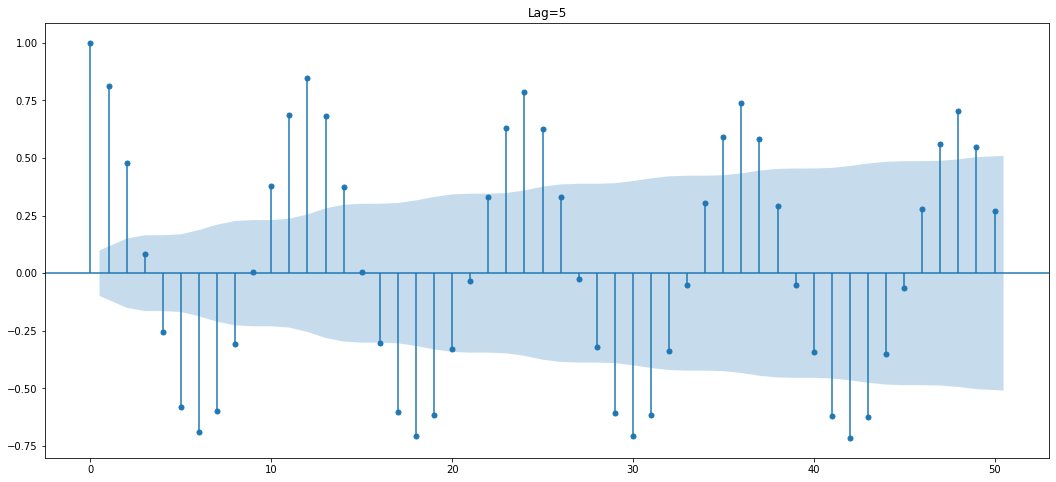

In [47]:
plot_acf(train.diff(periods=5).dropna(), lags=50, title="Lag=5") 
plt.show()

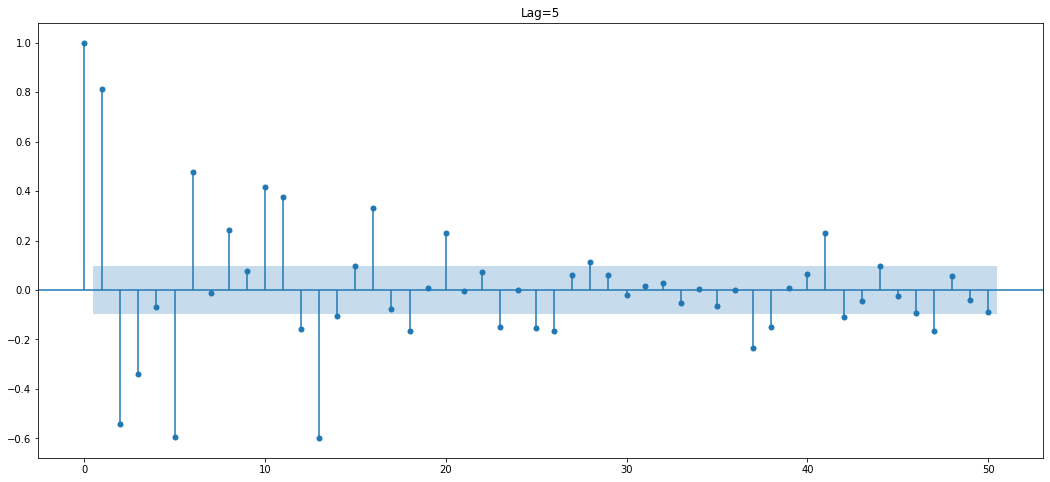

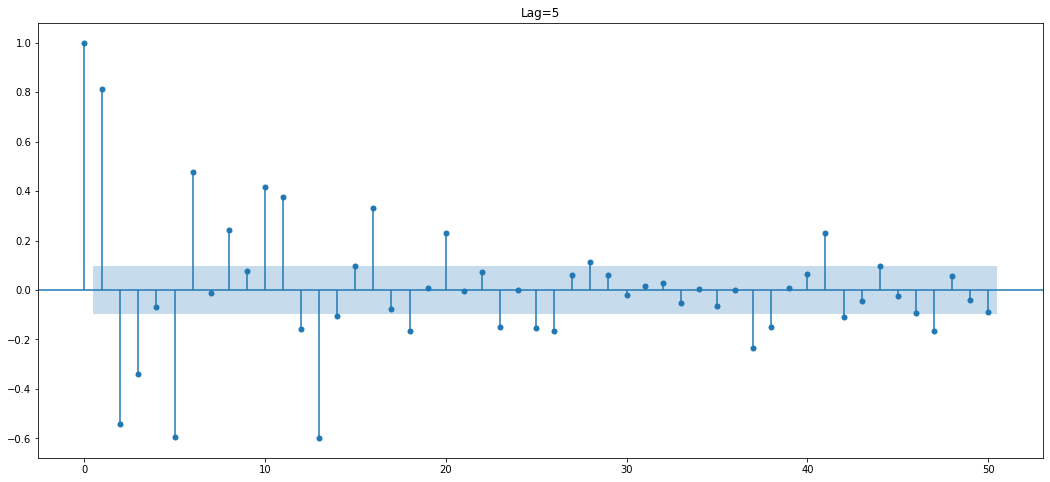

In [48]:
plot_pacf(train.diff(periods=5).dropna(), lags=50, title="Lag=5")

Go back to <a href="#index">Content of the notebook index</a>

<a id='Section4'></a>
#  5. Time Series Forecasting analysis with ARIMA

- We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
- ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [49]:
import itertools

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
# so s=12

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


### Parameter Selection: 
- This step is parameter Selection for our Employed people ARIMA Time Series Model. 
- Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [50]:
import warnings

In [ ]:

warnings.filterwarnings("ignore")

# Original Training without transformation - exploring  ( non stationary data )
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [52]:
warnings.filterwarnings("ignore")

# Transformed data ( Stationary data lag 4 )
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.diff(periods=4).dropna(),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11616.958598439243
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:11043.110848211798
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:10614.693851242326
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10243.041850896367
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10628.258094477402
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10579.544942290504
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10291.257584878604
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10231.690850396262
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:11255.936862426503
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10827.150995770648
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:10358.911063392508
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:9990.025790857482
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:10843.455529026402
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:10783.989863972198
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:10066.613157134983
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:9991.469543216495
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:11157.180903507982
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:10596.7796172

In [40]:
# Observation: The above output suggests that ARIMA(0, 1, 1)x(0, 1, 1, 12)12 yields the lowest AIC value 
# that is - AIC:9738.28

In [ ]:
warnings.filterwarnings("ignore")

# Transformed data ( Stationary data lag 5 )

lstAIC = []
lstParam = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.diff(periods=5).dropna(),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                           )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            lstAIC.append(results.aic)
            lstParam.append((param, param_seasonal))
        
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11669.644647954587
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:11099.69109144955
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:10707.356545548308
ARIMA(0, 0, 0)x(0, 0, 3, 12)12 - AIC:10316.378624303132
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:10705.5140387899
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10332.002683557235
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:9979.456114711562
ARIMA(0, 0, 0)x(0, 1, 3, 12)12 - AIC:9627.737272779312
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:10698.911077689814
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:10152.896452113666
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:9729.261822920904
ARIMA(0, 0, 0)x(0, 2, 3, 12)12 - AIC:9339.400526350602
ARIMA(0, 0, 0)x(0, 3, 0, 12)12 - AIC:2744946.069907557
ARIMA(0, 0, 0)x(0, 3, 1, 12)12 - AIC:2737077.5931871864
ARIMA(0, 0, 0)x(0, 3, 2, 12)12 - AIC:2726674.3178047338
ARIMA(0, 0, 0)x(0, 3, 3, 12)12 - AIC:13513.784445260539
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10717.623048423622
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10666.979839716556


ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:9963.673965395483
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:9807.707136383848
ARIMA(0, 0, 2)x(1, 1, 3, 12)12 - AIC:9454.63562488521
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:10023.300666251089
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:9897.28234551532
ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:9556.19896657695
ARIMA(0, 0, 2)x(1, 2, 3, 12)12 - AIC:9216.72970259196
ARIMA(0, 0, 2)x(1, 3, 0, 12)12 - AIC:10020.541067175105
ARIMA(0, 0, 2)x(1, 3, 1, 12)12 - AIC:9949.979308597663
ARIMA(0, 0, 2)x(1, 3, 2, 12)12 - AIC:9626.966380605088
ARIMA(0, 0, 2)x(1, 3, 3, 12)12 - AIC:9237.82679043915
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:10488.187658833778
ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:10488.367777072192
ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:10404.291975732292
ARIMA(0, 0, 2)x(2, 0, 3, 12)12 - AIC:10065.805511643164
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:9721.467015600596
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:9716.608548412403
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:9629.525520949992
ARIMA(0, 

ARIMA(0, 1, 0)x(2, 2, 2, 12)12 - AIC:9217.994501992504
ARIMA(0, 1, 0)x(2, 2, 3, 12)12 - AIC:8858.170165135076
ARIMA(0, 1, 0)x(2, 3, 0, 12)12 - AIC:9219.02250306963
ARIMA(0, 1, 0)x(2, 3, 1, 12)12 - AIC:9198.09797829151
ARIMA(0, 1, 0)x(2, 3, 2, 12)12 - AIC:9051.195982977144
ARIMA(0, 1, 0)x(2, 3, 3, 12)12 - AIC:850393.793640572
ARIMA(0, 1, 0)x(3, 0, 0, 12)12 - AIC:9478.595600701752
ARIMA(0, 1, 0)x(3, 0, 1, 12)12 - AIC:9444.245690391723
ARIMA(0, 1, 0)x(3, 0, 2, 12)12 - AIC:9445.66619729208
ARIMA(0, 1, 0)x(3, 0, 3, 12)12 - AIC:9415.454373840797
ARIMA(0, 1, 0)x(3, 1, 0, 12)12 - AIC:9143.72477433698
ARIMA(0, 1, 0)x(3, 1, 1, 12)12 - AIC:9122.598142898336
ARIMA(0, 1, 0)x(3, 1, 2, 12)12 - AIC:9128.371976532264
ARIMA(0, 1, 0)x(3, 1, 3, 12)12 - AIC:9097.009530517253
ARIMA(0, 1, 0)x(3, 2, 0, 12)12 - AIC:9003.457386113521
ARIMA(0, 1, 0)x(3, 2, 1, 12)12 - AIC:8905.654157844408
ARIMA(0, 1, 0)x(3, 2, 2, 12)12 - AIC:8879.956632052732
ARIMA(0, 1, 0)x(3, 2, 3, 12)12 - AIC:8854.100953309688
ARIMA(0, 1, 0)x

ARIMA(0, 1, 2)x(3, 3, 3, 12)12 - AIC:8990.30615216446
ARIMA(0, 1, 3)x(0, 0, 0, 12)12 - AIC:10965.646805522274
ARIMA(0, 1, 3)x(0, 0, 1, 12)12 - AIC:10528.109416758627
ARIMA(0, 1, 3)x(0, 0, 2, 12)12 - AIC:10177.098033676073
ARIMA(0, 1, 3)x(0, 0, 3, 12)12 - AIC:9824.314488376102
ARIMA(0, 1, 3)x(0, 1, 0, 12)12 - AIC:10045.259162943068
ARIMA(0, 1, 3)x(0, 1, 1, 12)12 - AIC:9641.667066064098
ARIMA(0, 1, 3)x(0, 1, 2, 12)12 - AIC:9322.300308286882
ARIMA(0, 1, 3)x(0, 1, 3, 12)12 - AIC:9005.340105906847
ARIMA(0, 1, 3)x(0, 2, 0, 12)12 - AIC:10092.082089017526
ARIMA(0, 1, 3)x(0, 2, 1, 12)12 - AIC:9601.313230077343
ARIMA(0, 1, 3)x(0, 2, 2, 12)12 - AIC:9248.28054293962
ARIMA(0, 1, 3)x(0, 2, 3, 12)12 - AIC:8913.294128197182
ARIMA(0, 1, 3)x(0, 3, 0, 12)12 - AIC:1209273.0387828606
ARIMA(0, 1, 3)x(0, 3, 1, 12)12 - AIC:1260829.043790199
ARIMA(0, 1, 3)x(0, 3, 2, 12)12 - AIC:13903.607349500982
ARIMA(0, 1, 3)x(0, 3, 3, 12)12 - AIC:13143.513347737076
ARIMA(0, 1, 3)x(1, 0, 0, 12)12 - AIC:10554.69961242302
ARIM

ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:9837.086124638252
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:9756.679834908675
ARIMA(0, 2, 1)x(1, 1, 2, 12)12 - AIC:9419.02118110036
ARIMA(0, 2, 1)x(1, 1, 3, 12)12 - AIC:9096.013664907045
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:9811.136138069076
ARIMA(0, 2, 1)x(1, 2, 1, 12)12 - AIC:9684.123934767333
ARIMA(0, 2, 1)x(1, 2, 2, 12)12 - AIC:9372.705364221987
ARIMA(0, 2, 1)x(1, 2, 3, 12)12 - AIC:9056.663530693571
ARIMA(0, 2, 1)x(1, 3, 0, 12)12 - AIC:9863.943529223612
ARIMA(0, 2, 1)x(1, 3, 1, 12)12 - AIC:9866.24580253978
ARIMA(0, 2, 1)x(1, 3, 2, 12)12 - AIC:9340.639477650937
ARIMA(0, 2, 1)x(1, 3, 3, 12)12 - AIC:9059.1942025084
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:10263.506160506106
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:10261.83692311254
ARIMA(0, 2, 1)x(2, 0, 2, 12)12 - AIC:10206.698743839574
ARIMA(0, 2, 1)x(2, 0, 3, 12)12 - AIC:9872.15991019061
ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:9492.725373657824
ARIMA(0, 2, 1)x(2, 1, 1, 12)12 - AIC:9478.778215725688
ARIMA(0, 2, 1

ARIMA(0, 2, 3)x(2, 2, 1, 12)12 - AIC:9499.655750484833
ARIMA(0, 2, 3)x(2, 2, 2, 12)12 - AIC:9385.516107635893
ARIMA(0, 2, 3)x(2, 2, 3, 12)12 - AIC:9047.446607506943
ARIMA(0, 2, 3)x(2, 3, 0, 12)12 - AIC:9550.755822246592
ARIMA(0, 2, 3)x(2, 3, 1, 12)12 - AIC:9553.961159418865
ARIMA(0, 2, 3)x(2, 3, 2, 12)12 - AIC:9420.936318288179
ARIMA(0, 2, 3)x(2, 3, 3, 12)12 - AIC:9074.701815082146
ARIMA(0, 2, 3)x(3, 0, 0, 12)12 - AIC:9931.56845412324
ARIMA(0, 2, 3)x(3, 0, 1, 12)12 - AIC:9931.0731269225
ARIMA(0, 2, 3)x(3, 0, 2, 12)12 - AIC:9931.524397724475
ARIMA(0, 2, 3)x(3, 0, 3, 12)12 - AIC:9822.013423515327
ARIMA(0, 2, 3)x(3, 1, 0, 12)12 - AIC:9202.30122088929
ARIMA(0, 2, 3)x(3, 1, 1, 12)12 - AIC:9196.258436711883
ARIMA(0, 2, 3)x(3, 1, 2, 12)12 - AIC:9192.776080140018
ARIMA(0, 2, 3)x(3, 1, 3, 12)12 - AIC:9089.080388297385
ARIMA(0, 2, 3)x(3, 2, 0, 12)12 - AIC:9183.507310886454
ARIMA(0, 2, 3)x(3, 2, 1, 12)12 - AIC:9160.764788027576
ARIMA(0, 2, 3)x(3, 2, 2, 12)12 - AIC:9158.569295326215
ARIMA(0, 2, 3)

In [117]:
min(lstAIC)

11071.689126596837

In [ ]:
lstParam[lstAIC.index(min(lstAIC))]

In [42]:
# Observation: The above output suggests that ARIMA(0, 1, 1)x(0, 1, 1, 12)12 yields the lowest AIC value 
# that is - AIC:9734.92

### Conclusion:
- For both the lags that is for 4 and 5 we are getting the same model ARIMA(0, 1, 1)x(0, 1, 1, 12)12 in case of lag 5 we are having the AIC value:9734.92 lowest.


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=10609.802, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11642.960, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10879.842, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11234.446, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11647.770, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=10717.886, Time=0.20 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=10641.893, Time=0.39 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=10630.874, Time=0.58 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=10623.716, Time=0.70 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=10842.662, Time=0.11 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=10699.109, Time=0.47 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=10634.283, Time=0.77 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=10623.142, Time=0.73 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=10798.281, Time=0.24 sec
 ARIM

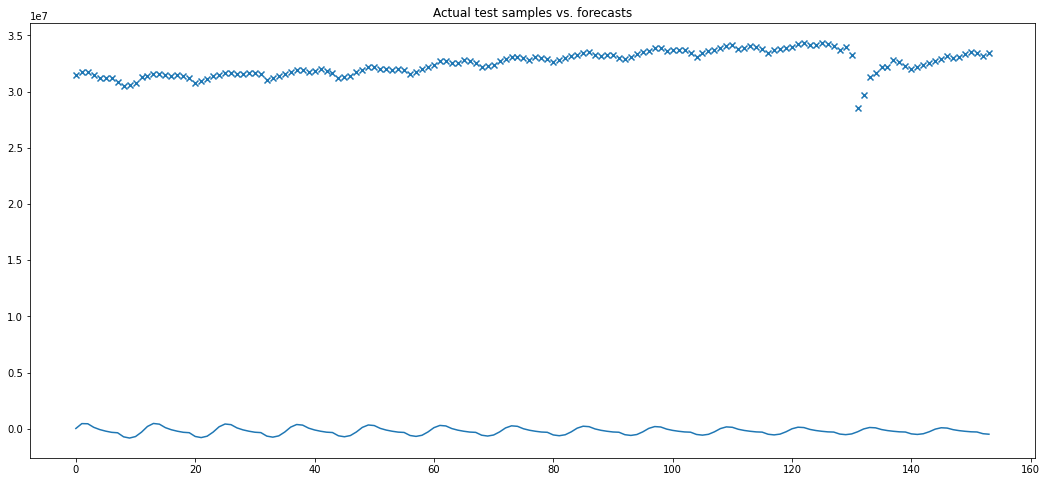

In [54]:
import pmdarima as pm
import numpy as np


# Fit a simple auto_arima model
arima = pm.auto_arima(train.diff(periods=4).dropna(), error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)
# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=10803.680, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11695.562, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10945.770, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11312.406, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11702.257, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=10898.975, Time=0.31 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=10803.563, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=11065.012, Time=0.11 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=10796.699, Time=0.73 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=10793.927, Time=0.85 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=10791.896, Time=0.89 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=10802.076, Time=0.81 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=10928.003, Time=0.81 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=10822.890, Time=0.72 sec
 ARIM

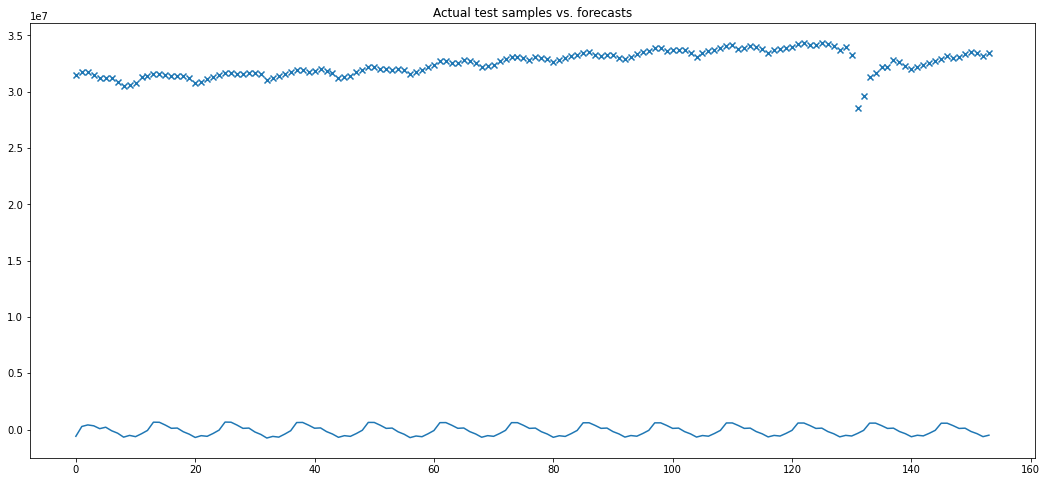

In [55]:
# Fit a simple auto_arima model
arima = pm.auto_arima(train.diff(periods=5).dropna(), error_action='ignore', trace=True,
                      suppress_warnings=False, maxiter=10,
                      seasonal=True, m=12)
# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

#Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=True, m=12)
#Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [56]:
from pandas.plotting import autocorrelation_plot

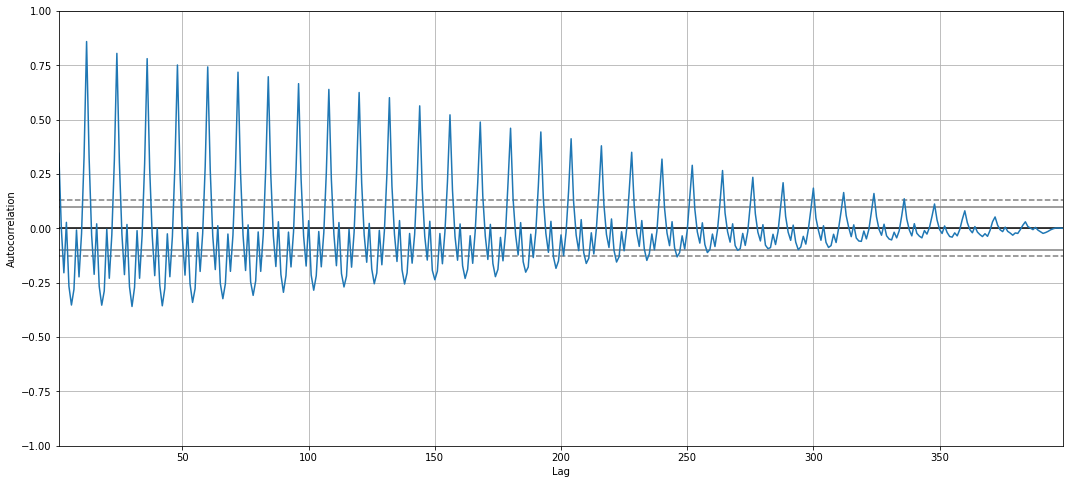

In [48]:
autocorrelation_plot(train.diff(periods=1).dropna())
plt.show()
# Observation: Since graph is tending to 0 hence its stationary

# 5. Time Series Forecasting analysis with SARIMA - Fitting, Validating

<AxesSubplot:xlabel='Monthly'>

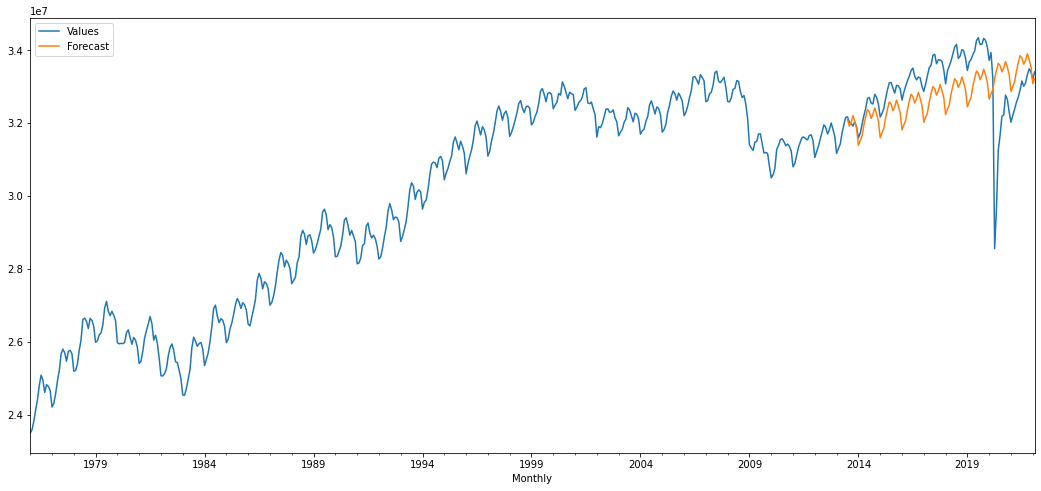

In [67]:
# Note we are passing data without transforming
#  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 

y=y[["Values"]]        
model = sm.tsa.statespace.SARIMAX(y,order=(0,1,1), 
                                  seasonal_order=(0,1,1,12),
                                  enforce_stationarity=True,
                                  enforce_invertibility=True)
results = model.fit()

y=y[["Values"]]
y['Forecast']=results.predict(start=450,end=553,dynamic=True)
y[['Values','Forecast']].plot()

In [ ]:
train, test = model_selection.train_test_split(y, train_size=450)

In [85]:
# Note we are passing data without transforming
#  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 
model = sm.tsa.statespace.SARIMAX(train,order=(0,1,1), seasonal_order=(0,1,1,12), enforce_stationarity=True,
                                enforce_invertibility=True)
results = model.fit()

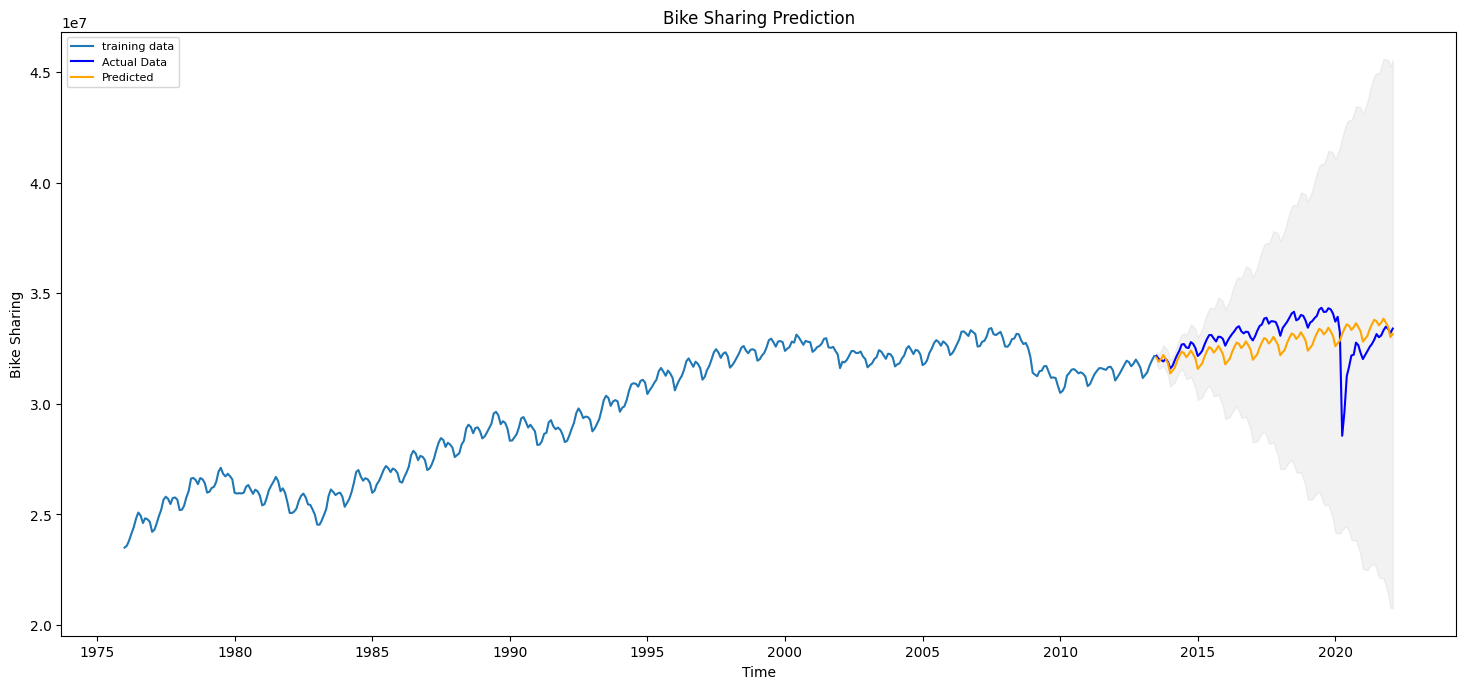

In [87]:
fc=results.get_forecast(len(test), alpha=0.05).summary_frame()
fc_series = pd.Series(fc['mean'], index=test.index)
lower_series = pd.Series(fc['mean_ci_lower'], index=test.index)
upper_series = pd.Series(fc['mean_ci_upper'], index=test.index)
plt.figure( dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Data')
plt.plot(fc_series, color='orange', label='Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05)
plt.title("Employed Persons in Midwest Census Region")
plt.xlabel("Time")
plt.ylabel("SARIMA - ")
plt.legend(loc="upper left", fontsize=8)
plt.show()

In [62]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Values   No. Observations:                  554
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -7648.788
Date:                            Sun, 15 May 2022   AIC                          15303.576
Time:                                    12:27:32   BIC                          15316.457
Sample:                                01-01-1976   HQIC                         15308.613
                                     - 02-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0034      0.014      0.253      0.801      -0.023       0.030
ma.S.L12      -0.0570      0.003    -17.058      0.000      -0.064      -0.050
sigma2      1.152e+11   1.09e-13   1.05e+24      0.000    1.15e+11    1.15e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):            471175.71
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):              13.09   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                       147.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+38. Standard errors may be unstable.
"""

In [110]:
def calculate_accuracy(final_df):
    from sklearn.metrics import mean_absolute_error
    #final_df = results.set_index('ds')

    pdTemp=final_df[['y', 'yhat']]
    
    # calculate Mean Absolute Error (MAE) between expected and predicted values for december
    y_true = pdTemp.dropna()['y'].values
    y_pred = pdTemp.dropna()['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    print(': MAE: %.3f' % mae)

    eval_df = pdTemp.dropna()[['y', 'yhat']]
    eval_df['abs_error'] = abs(eval_df['y'] - eval_df['yhat'])
    total_y = sum(eval_df['y'])
    total_error=sum(eval_df['abs_error'])
    forecast_acc=1-(total_error/total_y)
    print("Forecating Accuracy (RMSE): ", forecast_acc)

    eval_df['abs_error'].plot(title='Absolute Error plot')
    plt.plot()

    return

: MAE: 782808.399
Forecating Accuracy (RMSE):  0.9762853924425463


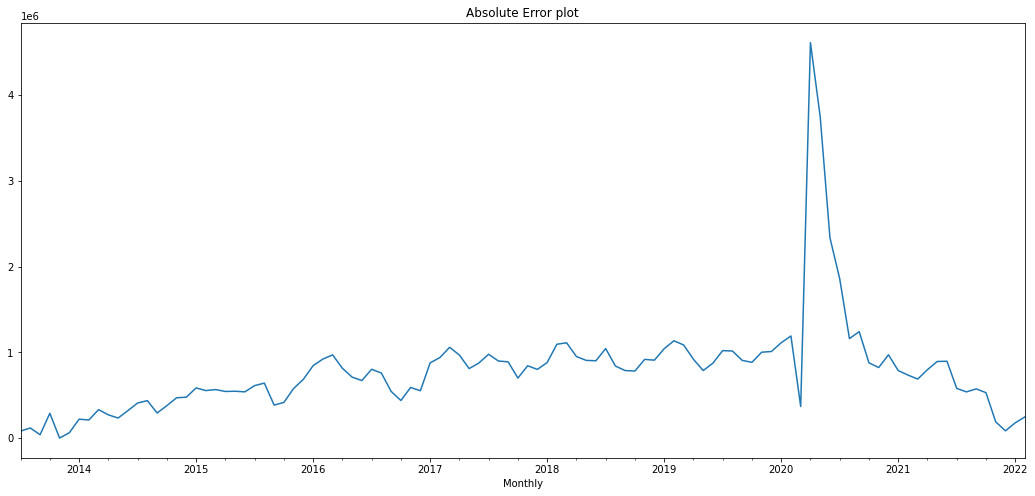

In [111]:
# Calculating the Final Result
final = test[['Values']].rename(columns={"Values": "y"})
final['yhat'] = fc['mean']
calculate_accuracy(final)

In [51]:
# Include forecasting upto 2025
# Do not remove the data from 2019s 

<AxesSubplot:xlabel='Monthly'>

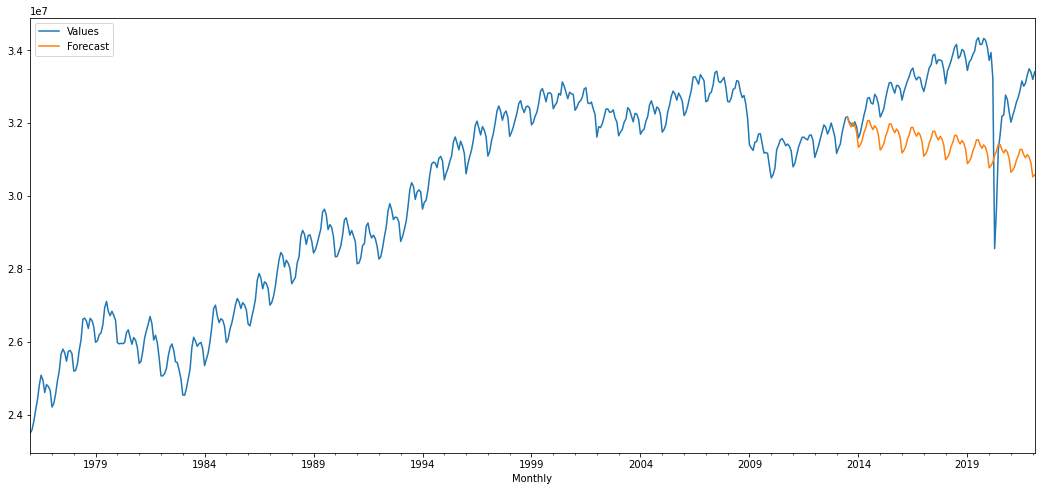

In [64]:
y=y[["Values"]]
#Best model:  ARIMA(5,0,2)(1,0,1)[12]
model = sm.tsa.statespace.SARIMAX(y,order=(5,0,2), seasonal_order=(1,0,1,12),
                                 enforce_stationarity=True,
                                enforce_invertibility=True)
results = model.fit()
results.summary()

y['Forecast']=results.predict(start=450,end=553,dynamic=True)
y[['Values','Forecast']].plot()

<AxesSubplot:xlabel='Monthly'>

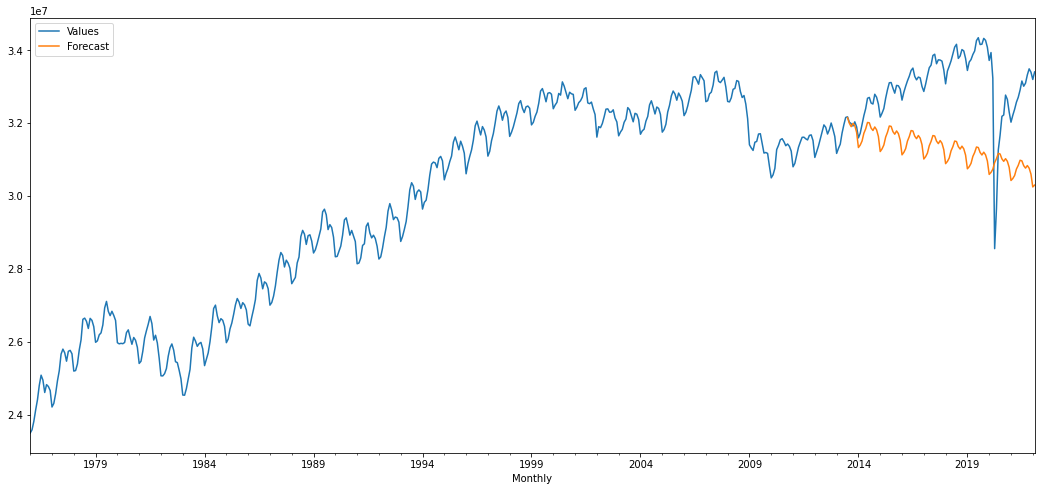

In [63]:
#Best model:  ARIMA(5,0,2)(2,0,2)[12]
y=y[["Values"]]

model = sm.tsa.statespace.SARIMAX(y,order=(5,0,2), seasonal_order=(2,0,2,12),
                                 enforce_stationarity=True,
                                enforce_invertibility=True)
results = model.fit()
results.summary()

y['Forecast']=results.predict(start=450,end=553,dynamic=True)
y[['Values','Forecast']].plot()

<a id='Section5'></a>
# 5. Facebook Prophet

Implemented in seperate notebook

Go back to <a href="#index">Content of the notebook index</a>

# References:
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b 
- Stationarity and non-stationarity: https://machinelearningmastery.com/time-series-data-stationary-python/
- https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/07e04fb0-9eaf-44fa-b064-7ac9856b2881/view?access_token=4c59dfbbf611086f25d77bd305057babed2d9c523645d57f67b0d98379a8e35f
- https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data